In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
import typing_extensions
from importlib import reload
reload(typing_extensions)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
sns.set_theme(style="whitegrid")

In [20]:
X_train = np.load('data/X_train.npy')
y_train = np.load('data/y_train.npy')
X_val = np.load('data/X_val.npy')
y_val = np.load('data/y_val.npy')
X_test = np.load('data/X_test.npy')

In [4]:
def model_train_and_tune(model, param_grid, X_train, y_train, random_search=False):
    if random_search:
        grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring="neg_root_mean_squared_log_error", n_jobs=-1, verbose=2)
    else:
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring="neg_root_mean_squared_log_error", n_jobs=-1, verbose=2)

    grid_search.fit(X_train, y_train)

    return grid_search.best_score_, grid_search.best_params_, grid_search.best_estimator_

In [14]:
model = LinearRegression()
param_grid = {
    "fit_intercept": [True, False]
}
score, params, lr_model = model_train_and_tune(model, param_grid, X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


c:\Users\ivan.trujillo_blueta\proyectos\personal\abalone_regression\venv\lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


In [5]:
def print_results(score, params):
    print(f"Best score: {score}")
    print(f"Best params: {params}")

In [16]:
print_results(score, params)

Best score: nan
Best params: {'fit_intercept': True}


In [6]:
def custom_root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(np.sum(np.square(np.log1p(1 + y_pred) - np.log1p(1 + y_true))) / len(y_true))

In [21]:
custom_root_mean_squared_log_error(y_val, lr_model.predict(X_val))

0.1525064342164683

In [24]:
model = RandomForestRegressor()
param_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}
score, params, rf_model = model_train_and_tune(model, param_grid, X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [25]:
print_results(score, params)

Best score: -0.1509465863210951
Best params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 400}


In [26]:
custom_root_mean_squared_log_error(y_val, rf_model.predict(X_val))

0.13978866449684338

In [29]:
model = SVR()
param_grid = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": [2, 3, 4],
    "C": [0.1, 1, 10],
}
score, params, svr_model = model_train_and_tune(model, param_grid, X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\ivan.trujillo_blueta\proyectos\personal\abalone_regression\venv\lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [-0.16582355 -0.16308887 -0.16126259         nan -0.16582355 -0.15999555
 -0.16126259         nan -0.16582355 -0.15872275 -0.16126259         nan
         nan -0.15735    -0.15579683         nan         nan -0.15603047
 -0.15579683         nan         nan -0.15540871 -0.15579683         nan
         nan -0.15564717 -0.15409424         nan         nan -0.15476496
 -0.15409424         nan         nan -0.15447111 -0.15409424         nan]
  warnings.warn(


In [30]:
print_results(score, params)

Best score: -0.15409423751671805
Best params: {'C': 10, 'degree': 2, 'kernel': 'rbf'}


In [31]:
custom_root_mean_squared_log_error(y_val, svr_model.predict(X_val))

0.14332240567697857

In [7]:
model = XGBRegressor()
param_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [None, 10, 20, 30],
    "learning_rate": [0.1, 0.01, 0.001],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10],
}
score, params, xgb_model = model_train_and_tune(model, param_grid, X_train, y_train, random_search=True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\ivan.trujillo_blueta\proyectos\personal\abalone_regression\venv\lib\site-packages\xgboost\core.py:160: UserWarning: [09:34:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


In [8]:
print_results(score, params)

Best score: -0.1501723584133206
Best params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'learning_rate': 0.1}


In [9]:
custom_root_mean_squared_log_error(y_val, xgb_model.predict(X_val))

0.1385064949052753

In [8]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [11]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
dnn = DNN()

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(dnn.parameters(), lr=0.001)

for epoch in range(100):
    dnn.train()
    for i, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = dnn(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch} loss: {loss.item()}")

c:\Users\ivan.trujillo_blueta\proyectos\personal\abalone_regression\venv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\ivan.trujillo_blueta\proyectos\personal\abalone_regression\venv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 loss: 13.181525230407715
Epoch 1 loss: 12.919066429138184
Epoch 2 loss: 5.441035270690918
Epoch 3 loss: 1.9387834072113037
Epoch 4 loss: 17.4000301361084
Epoch 5 loss: 6.0358195304870605
Epoch 6 loss: 16.636863708496094
Epoch 7 loss: 13.617465019226074
Epoch 8 loss: 11.528886795043945
Epoch 9 loss: 5.734281063079834
Epoch 10 loss: 6.811122417449951
Epoch 11 loss: 11.491414070129395
Epoch 12 loss: 3.0693132877349854
Epoch 13 loss: 6.166163921356201
Epoch 14 loss: 9.289852142333984
Epoch 15 loss: 18.892471313476562
Epoch 16 loss: 21.363914489746094
Epoch 17 loss: 3.957319974899292
Epoch 18 loss: 8.07120418548584
Epoch 19 loss: 15.87216567993164
Epoch 20 loss: 13.27161693572998
Epoch 21 loss: 2.4916586875915527
Epoch 22 loss: 5.979252815246582
Epoch 23 loss: 9.06399154663086
Epoch 24 loss: 6.111563682556152
Epoch 25 loss: 8.23134994506836
Epoch 26 loss: 5.718852996826172
Epoch 27 loss: 6.212822437286377
Epoch 28 loss: 5.251081943511963
Epoch 29 loss: 5.272771835327148
Epoch 30 los

In [13]:
dnn.eval()
y_pred = dnn(X_val_tensor).detach().numpy()
custom_root_mean_squared_log_error(y_val, y_pred)

35.672889653620686

In [14]:
y_val

array([ 7,  7,  9, ..., 11, 10, 13], dtype=int64)

In [16]:
best_xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=None,
    learning_rate=0.1,
    min_samples_leaf=2,
    min_samples_split=5
)

In [17]:
best_xgb_model.fit(X_train, y_train)

c:\Users\ivan.trujillo_blueta\proyectos\personal\abalone_regression\venv\lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, min_samples_leaf=2, min_samples_split=5,
             missing=nan, monotone_constraints=None, multi_strategy=None,
             n_estimators=300, n_jobs=None, ...)

In [37]:
best_xgb_model.feature_importances_ * 100

array([ 2.0761776,  1.8605018,  4.0112495,  3.8485115, 10.413257 ,
        2.0396724, 63.766716 ,  1.5606034,  8.833402 ,  1.5899012],
      dtype=float32)

In [40]:
features = ["Length", "Diameter", "Height", "Whole weight", "Whole weight.1", "Whole weight.2", "Shell weight", "Sex_F", "Sex_I", "Sex_M"]

<Axes: >

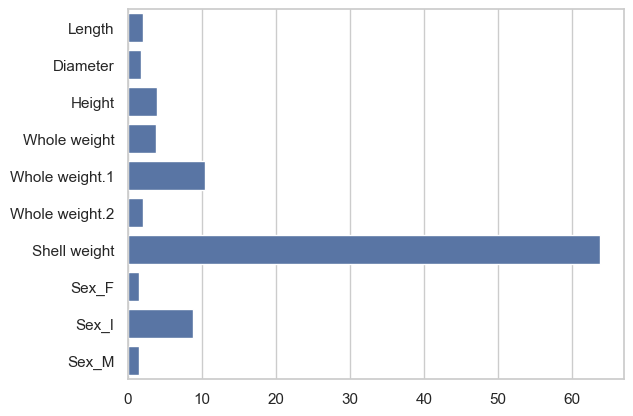

In [41]:
sns.barplot(x=best_xgb_model.feature_importances_ * 100, y=features)

In [24]:
y_pred = best_xgb_model.predict(X_val)
y_pred = np.array(y_pred, dtype=np.int32)
custom_root_mean_squared_log_error(y_val, y_pred)

0.14566423870566664

0.14566423870566664

In [25]:
y_pred = best_xgb_model.predict(X_test)
y_pred = np.array(y_pred, dtype=np.int32)

In [26]:
y_pred

array([ 9,  9, 10, ..., 12, 13,  8])

In [27]:
test_pd = pd.read_csv('data/test.csv')

In [28]:
test_pd.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


In [33]:
result = pd.concat([test_pd['id'], pd.DataFrame(y_pred, columns=["Rings"])], axis=1)

In [34]:
result

,id,Rings
0,90615,9
1,90616,9
2,90617,10
3,90618,10
4,90619,7
...,...,...
60406,151021,6
60407,151022,9
60408,151023,12
60409,151024,13


In [35]:
result.to_csv('data/submission_file.csv', index=False)

In [43]:
best_xgb_model.save_model('models/abalone_xgb_model.json')